# Project: Twitter Insight on WeRateDogs

# Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
    <ul><li><a href="#gather">Gather three datasets</a></li></ul>
    <ul><li><a href="#assess_and_clean">Start to assess and clean</a></li></ul>
    <ul><li><a href="#store">Store clean dataset</a></li></ul>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>

# Introduction
WeRateDogs project from Data Analyst Nanodegree.

Internal note to continue working on this notebook: first copy the credentials from `wrangle_act__with_credentials_for_twitter.ipynb`, and place them in this notebook

<a id='wrangling'></a>

# Data Wrangling

<a id='gather'></a>
## Gather Data

In [1]:
# import libraries
import pandas as pd
import requests, datetime, os, time, tweepy, json

### 1: Load WeRateDogs Twitter archive

In [2]:
# note warning in class concerning file 'twitter-archive-enhanced.csv':
# 'The ratings probably aren't all correct. Same goes for the dog names and probably dog stages (see below for more information on these) too. You'll need to assess and clean these columns if you want to use them for analysis and visualization.'

# read CSV to DataFrame
archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
# get an idea that it was successful
# as in "Project Motivation" we have 2356 entries
# only tweets with ratings
archive.shape

(2356, 17)

### 2: Tweet image predictions

In [4]:
# URL to image_predictions.tsv
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
# we use byte format to write the data to disk (existing file is replaced):
with open('image_predictions.tsv', mode = 'wb') as file:
    file.write(response.content)

In [5]:
# check that file is created
os.listdir()

['wrangle_report.html',
 'wrangle_act.ipynb',
 'twitter-archive-enhanced.csv',
 'wrangle_act__with_credentials_for_twitter.ipynb',
 'tweet-json copy',
 'image_predictions.tsv',
 'Udacity Reviews.pdf',
 'tweet_json copy 20190512.txt',
 'wrangle_act.html',
 'twitter-api.rtf',
 'act_report.html',
 'twitter_archive_master.csv',
 '.ipynb_checkpoints',
 'wrangle_report.ipynb',
 'act_report.ipynb',
 'tweet_json.txt',
 'tweet-json.zip']

In [6]:
image_pred = pd.read_csv('image_predictions.tsv', '\t')

### 3. Likes from Twitter API

In [7]:
# no NaN in tweet_id
archive.tweet_id.isna().sum()

0

In [8]:
# no duplicated IDs in Archive
(archive.tweet_id.duplicated()).sum()

0

#### Reading Tweets using Tweepy

In [9]:
consumer_key = 'YOUR CONSUMER KEY'
consumer_secret = 'YOUR CONSUMER SECRET'
access_token = 'YOUR ACCESS TOKEN'
access_secret = 'YOUR ACCESS SECRET'

#consumer_key = 'REMOVED FOR SUBMISSION'
#consumer_secret = 'REMOVED FOR SUBMISSION'
#access_token = 'REMOVED FOR SUBMISSION'
#access_secret = 'REMOVED FOR SUBMISSION'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, 
                 wait_on_rate_limit_notify = True)

##### Learn: read 1 Twitter post, write it to tweet_json.txt

In [10]:
# make sure we have nothing in 'tweet_json.txt' 
with open('tweet_json.txt', 'w', encoding = 'utf-8') as myfile:
    myfile.write('')

In [11]:
# reference:
# https://twitter.com/dog_rates
# https://twitter.com/dog_rates/status/892420643555336193

# read info for 1 tweet
# inspired by https://knowledge.udacity.com/questions/39727
tweet = api.get_status(archive.tweet_id[0], tweet_mode = 'extended')
archive.tweet_id[0], tweet.favorite_count

(892420643555336193, 37545)

In [12]:
# write info for 1 post
with open('tweet_json.txt', 'w', encoding = 'utf-8') as file:
    json.dump(tweet._json, file)

##### Learn: read 2 Twitter posts, write it to tweet_json.txt

In [13]:
# clean 'tweet_json.txt'
with open('tweet_json.txt', 'w', encoding = 'utf-8') as myfile:
    myfile.write('')

In [14]:
# practice with two Tweet IDs
tweet_ids = archive.tweet_id[0:2]
tweet_ids
# ID1: https://twitter.com/dog_rates/status/892420643555336193
# ID2: https://twitter.com/dog_rates/status/892177421306343426

0    892420643555336193
1    892177421306343426
Name: tweet_id, dtype: int64

In [15]:
# read info for 2 tweets
# write content to file directly after receiving the information, i.e. before next loop run 
for tweet_id in tweet_ids:
    tweet = api.get_status(tweet_id, tweet_mode = 'extended')

    # https://www.programiz.com/python-programming/methods/built-in/open
    # mode 'a' -> "Open for appending at the end of the file"
    with open('tweet_json.txt', mode = 'a', encoding = 'utf-8') as file:
        json.dump(tweet._json, file)
        file.write('\n') # new line for next entry

##### In the Archive Tweet_IDs data we have entries until August 2017
Possibilites:
1. filter Tweet_IDs in 'twitter-archive-enhanced.csv' before obtaining information using Tweepy
2. do not filter Tweet_IDs but filter on the Tweepy results

$\rightarrow$ Use second possibility for data quality reasons: to apply the Tweet ID filter on the original data (directly querying Twitter) reduces possible errors

##### Learn: filter by date

In [16]:
# filter tweets beyond August 1st, 2017
# use datetime 
# inspired by https://stackoverflow.com/questions/7239315/cant-compare-datetime-datetime-to-datetime-date

# comparison on Tweepy output works as expected:
print(datetime.datetime(2017, 1, 1) < datetime.datetime(2017, 1, 2))
print(datetime.datetime(2017, 1, 2) < datetime.datetime(2017, 1, 2))
print(tweet.created_at)
print('is in considered time period?: ', 
      tweet.created_at < datetime.datetime(2017, 1, 2))

True
False
2017-08-01 00:17:27
is in considered time period?:  False


##### Learn: exclude retweets

In [17]:
# look for retweeted post: 1121911827275718656
tweet = api.get_status('1121911827275718656')
# scroll through JSON output which is formatted more readable 
# using https://jsonformatter.curiousconcept.com
tweet.is_quote_status

True

In [18]:
# look for a not retweeted post: 892420643555336193
tweet = api.get_status('892420643555336193')
# scroll through JSON output which is formatted more readable 
# using https://jsonformatter.curiousconcept.com
tweet.is_quote_status

False

##### For all Tweets: programmatically with a loop

In [19]:
# clean 'tweet_json.txt' before running loop
with open('tweet_json.txt', 'w', encoding = 'utf-8') as myfile:
    myfile.write('')

In [20]:
# full loop running 32 min
# checks 2356 Tweet IDs
# 2325 lines written to 'tweet_json.txt'
# 19 times "No status found with that ID."

# output examples:
# deleted ID:
# -  "ID# 156 after 28 s: get info for Tweet_ID 861769973181624320 ...
#    [{'code': 144, 'message': 'No status found with that ID.'}]"
# last Tweet ID:
#    ID# 2356 after 1910 s: get info for Tweet_ID 666020888022790149 ...
#    older than 02.08.2017 & not retweed -> write line  2325

start = time.time()
count_requests = 0
count_written_lines = 0
count_errors = 0

for tweet_id in archive.tweet_id:
    count_requests += 1
    print('ID#', count_requests, 'after', round(time.time() - start), 's: get info for Tweet_ID', tweet_id, '...')
    
    # exception handling inspired by https://wiki.python.org/moin/HandlingExceptions
    try:
        tweet = api.get_status(tweet_id, tweet_mode = 'extended')
        
    # inspired for how to catch the exception by https://stackoverflow.com/questions/17157753/get-the-error-code-from-tweepy-exception-instance:
    except tweepy.TweepError as e:
        count_errors += 1
        print(e)

    if tweet.created_at < datetime.datetime(2017, 8, 2):
        if tweet.is_quote_status == False:
            count_written_lines += 1
            print('older than 02.08.2017 & no retweet -> write line ', count_written_lines)
            with open('tweet_json.txt', 'a', encoding = 'utf-8') as file:
                json.dump(tweet._json, file)
                file.write('\n')
   # if count_requests == 5:
   #     break

ID# 1 after 0 s: get info for Tweet_ID 892420643555336193 ...
older than 02.08.2017 & no retweet -> write line  1
ID# 2 after 0 s: get info for Tweet_ID 892177421306343426 ...
older than 02.08.2017 & no retweet -> write line  2
ID# 3 after 1 s: get info for Tweet_ID 891815181378084864 ...
older than 02.08.2017 & no retweet -> write line  3
ID# 4 after 1 s: get info for Tweet_ID 891689557279858688 ...
older than 02.08.2017 & no retweet -> write line  4
ID# 5 after 2 s: get info for Tweet_ID 891327558926688256 ...
older than 02.08.2017 & no retweet -> write line  5
ID# 6 after 2 s: get info for Tweet_ID 891087950875897856 ...
older than 02.08.2017 & no retweet -> write line  6
ID# 7 after 2 s: get info for Tweet_ID 890971913173991426 ...
older than 02.08.2017 & no retweet -> write line  7
ID# 8 after 3 s: get info for Tweet_ID 890729181411237888 ...
older than 02.08.2017 & no retweet -> write line  8
ID# 9 after 3 s: get info for Tweet_ID 890609185150312448 ...
older than 02.08.2017 & no

older than 02.08.2017 & no retweet -> write line  69
ID# 73 after 28 s: get info for Tweet_ID 878604707211726852 ...
ID# 74 after 28 s: get info for Tweet_ID 878404777348136964 ...
older than 02.08.2017 & no retweet -> write line  70
ID# 75 after 29 s: get info for Tweet_ID 878316110768087041 ...
older than 02.08.2017 & no retweet -> write line  71
ID# 76 after 29 s: get info for Tweet_ID 878281511006478336 ...
older than 02.08.2017 & no retweet -> write line  72
ID# 77 after 30 s: get info for Tweet_ID 878057613040115712 ...
older than 02.08.2017 & no retweet -> write line  73
ID# 78 after 30 s: get info for Tweet_ID 877736472329191424 ...
older than 02.08.2017 & no retweet -> write line  74
ID# 79 after 30 s: get info for Tweet_ID 877611172832227328 ...
older than 02.08.2017 & no retweet -> write line  75
ID# 80 after 31 s: get info for Tweet_ID 877556246731214848 ...
older than 02.08.2017 & no retweet -> write line  76
ID# 81 after 31 s: get info for Tweet_ID 877316821321428993 ...


older than 02.08.2017 & no retweet -> write line  134
ID# 143 after 57 s: get info for Tweet_ID 864279568663928832 ...
older than 02.08.2017 & no retweet -> write line  135
ID# 144 after 58 s: get info for Tweet_ID 864197398364647424 ...
older than 02.08.2017 & no retweet -> write line  136
ID# 145 after 58 s: get info for Tweet_ID 863907417377173506 ...
older than 02.08.2017 & no retweet -> write line  137
ID# 146 after 58 s: get info for Tweet_ID 863553081350529029 ...
older than 02.08.2017 & no retweet -> write line  138
ID# 147 after 59 s: get info for Tweet_ID 863471782782697472 ...
older than 02.08.2017 & no retweet -> write line  139
ID# 148 after 59 s: get info for Tweet_ID 863432100342583297 ...
older than 02.08.2017 & no retweet -> write line  140
ID# 149 after 60 s: get info for Tweet_ID 863427515083354112 ...
older than 02.08.2017 & no retweet -> write line  141
ID# 150 after 60 s: get info for Tweet_ID 863079547188785154 ...
older than 02.08.2017 & no retweet -> write line

older than 02.08.2017 & no retweet -> write line  201
ID# 212 after 84 s: get info for Tweet_ID 851953902622658560 ...
older than 02.08.2017 & no retweet -> write line  202
ID# 213 after 85 s: get info for Tweet_ID 851861385021730816 ...
older than 02.08.2017 & no retweet -> write line  203
ID# 214 after 85 s: get info for Tweet_ID 851591660324737024 ...
older than 02.08.2017 & no retweet -> write line  204
ID# 215 after 86 s: get info for Tweet_ID 851464819735769094 ...
older than 02.08.2017 & no retweet -> write line  205
ID# 216 after 86 s: get info for Tweet_ID 851224888060895234 ...
older than 02.08.2017 & no retweet -> write line  206
ID# 217 after 86 s: get info for Tweet_ID 850753642995093505 ...
older than 02.08.2017 & no retweet -> write line  207
ID# 218 after 87 s: get info for Tweet_ID 850380195714523136 ...
older than 02.08.2017 & no retweet -> write line  208
ID# 219 after 87 s: get info for Tweet_ID 850333567704068097 ...
older than 02.08.2017 & no retweet -> write line

older than 02.08.2017 & no retweet -> write line  266
ID# 281 after 112 s: get info for Tweet_ID 839549326359670784 ...
older than 02.08.2017 & no retweet -> write line  267
ID# 282 after 112 s: get info for Tweet_ID 839290600511926273 ...
older than 02.08.2017 & no retweet -> write line  268
ID# 283 after 113 s: get info for Tweet_ID 839239871831150596 ...
older than 02.08.2017 & no retweet -> write line  269
ID# 284 after 113 s: get info for Tweet_ID 838952994649550848 ...
ID# 285 after 113 s: get info for Tweet_ID 838921590096166913 ...
older than 02.08.2017 & no retweet -> write line  270
ID# 286 after 114 s: get info for Tweet_ID 838916489579200512 ...
older than 02.08.2017 & no retweet -> write line  271
ID# 287 after 114 s: get info for Tweet_ID 838831947270979586 ...
older than 02.08.2017 & no retweet -> write line  272
ID# 288 after 115 s: get info for Tweet_ID 838561493054533637 ...
older than 02.08.2017 & no retweet -> write line  273
ID# 289 after 115 s: get info for Tweet_

older than 02.08.2017 & no retweet -> write line  333
ID# 351 after 140 s: get info for Tweet_ID 831552930092285952 ...
older than 02.08.2017 & no retweet -> write line  334
ID# 352 after 140 s: get info for Tweet_ID 831322785565769729 ...
older than 02.08.2017 & no retweet -> write line  335
ID# 353 after 140 s: get info for Tweet_ID 831315979191906304 ...
older than 02.08.2017 & no retweet -> write line  336
ID# 354 after 141 s: get info for Tweet_ID 831309418084069378 ...
older than 02.08.2017 & no retweet -> write line  337
ID# 355 after 141 s: get info for Tweet_ID 831262627380748289 ...
older than 02.08.2017 & no retweet -> write line  338
ID# 356 after 142 s: get info for Tweet_ID 830956169170665475 ...
older than 02.08.2017 & no retweet -> write line  339
ID# 357 after 142 s: get info for Tweet_ID 830583320585068544 ...
older than 02.08.2017 & no retweet -> write line  340
ID# 358 after 142 s: get info for Tweet_ID 830173239259324417 ...
older than 02.08.2017 & no retweet -> wr

older than 02.08.2017 & no retweet -> write line  401
ID# 420 after 167 s: get info for Tweet_ID 822244816520155136 ...
older than 02.08.2017 & no retweet -> write line  402
ID# 421 after 167 s: get info for Tweet_ID 822163064745328640 ...
older than 02.08.2017 & no retweet -> write line  403
ID# 422 after 168 s: get info for Tweet_ID 821886076407029760 ...
older than 02.08.2017 & no retweet -> write line  404
ID# 423 after 168 s: get info for Tweet_ID 821813639212650496 ...
older than 02.08.2017 & no retweet -> write line  405
ID# 424 after 168 s: get info for Tweet_ID 821765923262631936 ...
older than 02.08.2017 & no retweet -> write line  406
ID# 425 after 169 s: get info for Tweet_ID 821522889702862852 ...
older than 02.08.2017 & no retweet -> write line  407
ID# 426 after 169 s: get info for Tweet_ID 821421320206483457 ...
older than 02.08.2017 & no retweet -> write line  408
ID# 427 after 170 s: get info for Tweet_ID 821407182352777218 ...
older than 02.08.2017 & no retweet -> wr

older than 02.08.2017 & no retweet -> write line  469
ID# 489 after 194 s: get info for Tweet_ID 813944609378369540 ...
older than 02.08.2017 & no retweet -> write line  470
ID# 490 after 194 s: get info for Tweet_ID 813910438903693312 ...
older than 02.08.2017 & no retweet -> write line  471
ID# 491 after 195 s: get info for Tweet_ID 813812741911748608 ...
older than 02.08.2017 & no retweet -> write line  472
ID# 492 after 195 s: get info for Tweet_ID 813800681631023104 ...
older than 02.08.2017 & no retweet -> write line  473
ID# 493 after 195 s: get info for Tweet_ID 813217897535406080 ...
older than 02.08.2017 & no retweet -> write line  474
ID# 494 after 196 s: get info for Tweet_ID 813202720496779264 ...
older than 02.08.2017 & no retweet -> write line  475
ID# 495 after 196 s: get info for Tweet_ID 813187593374461952 ...
older than 02.08.2017 & no retweet -> write line  476
ID# 496 after 197 s: get info for Tweet_ID 813172488309972993 ...
older than 02.08.2017 & no retweet -> wr

older than 02.08.2017 & no retweet -> write line  536
ID# 558 after 221 s: get info for Tweet_ID 803380650405482500 ...
older than 02.08.2017 & no retweet -> write line  537
ID# 559 after 222 s: get info for Tweet_ID 803321560782307329 ...
older than 02.08.2017 & no retweet -> write line  538
ID# 560 after 222 s: get info for Tweet_ID 803276597545603072 ...
older than 02.08.2017 & no retweet -> write line  539
ID# 561 after 222 s: get info for Tweet_ID 802952499103731712 ...
older than 02.08.2017 & no retweet -> write line  540
ID# 562 after 223 s: get info for Tweet_ID 802624713319034886 ...
older than 02.08.2017 & no retweet -> write line  541
ID# 563 after 223 s: get info for Tweet_ID 802600418706604034 ...
older than 02.08.2017 & no retweet -> write line  542
ID# 564 after 224 s: get info for Tweet_ID 802572683846291456 ...
older than 02.08.2017 & no retweet -> write line  543
ID# 565 after 224 s: get info for Tweet_ID 802323869084381190 ...
older than 02.08.2017 & no retweet -> wr

older than 02.08.2017 & no retweet -> write line  603
ID# 627 after 249 s: get info for Tweet_ID 795076730285391872 ...
older than 02.08.2017 & no retweet -> write line  604
ID# 628 after 249 s: get info for Tweet_ID 794983741416415232 ...
older than 02.08.2017 & no retweet -> write line  605
ID# 629 after 249 s: get info for Tweet_ID 794926597468000259 ...
older than 02.08.2017 & no retweet -> write line  606
ID# 630 after 250 s: get info for Tweet_ID 794355576146903043 ...
older than 02.08.2017 & no retweet -> write line  607
ID# 631 after 250 s: get info for Tweet_ID 794332329137291264 ...
older than 02.08.2017 & no retweet -> write line  608
ID# 632 after 251 s: get info for Tweet_ID 794205286408003585 ...
older than 02.08.2017 & no retweet -> write line  609
ID# 633 after 251 s: get info for Tweet_ID 793962221541933056 ...
older than 02.08.2017 & no retweet -> write line  610
ID# 634 after 251 s: get info for Tweet_ID 793845145112371200 ...
older than 02.08.2017 & no retweet -> wr

older than 02.08.2017 & no retweet -> write line  671
ID# 696 after 276 s: get info for Tweet_ID 786709082849828864 ...
older than 02.08.2017 & no retweet -> write line  672
ID# 697 after 276 s: get info for Tweet_ID 786664955043049472 ...
older than 02.08.2017 & no retweet -> write line  673
ID# 698 after 277 s: get info for Tweet_ID 786595970293370880 ...
older than 02.08.2017 & no retweet -> write line  674
ID# 699 after 277 s: get info for Tweet_ID 786363235746385920 ...
older than 02.08.2017 & no retweet -> write line  675
ID# 700 after 277 s: get info for Tweet_ID 786286427768250368 ...
older than 02.08.2017 & no retweet -> write line  676
ID# 701 after 278 s: get info for Tweet_ID 786233965241827333 ...
older than 02.08.2017 & no retweet -> write line  677
ID# 702 after 278 s: get info for Tweet_ID 786051337297522688 ...
older than 02.08.2017 & no retweet -> write line  678
ID# 703 after 279 s: get info for Tweet_ID 786036967502913536 ...
older than 02.08.2017 & no retweet -> wr

older than 02.08.2017 & no retweet -> write line  740
ID# 765 after 303 s: get info for Tweet_ID 777953400541634568 ...
older than 02.08.2017 & no retweet -> write line  741
ID# 766 after 303 s: get info for Tweet_ID 777885040357281792 ...
older than 02.08.2017 & no retweet -> write line  742
ID# 767 after 304 s: get info for Tweet_ID 777684233540206592 ...
older than 02.08.2017 & no retweet -> write line  743
ID# 768 after 304 s: get info for Tweet_ID 777641927919427584 ...
older than 02.08.2017 & no retweet -> write line  744
ID# 769 after 304 s: get info for Tweet_ID 777621514455814149 ...
older than 02.08.2017 & no retweet -> write line  745
ID# 770 after 305 s: get info for Tweet_ID 777189768882946048 ...
older than 02.08.2017 & no retweet -> write line  746
ID# 771 after 305 s: get info for Tweet_ID 776819012571455488 ...
older than 02.08.2017 & no retweet -> write line  747
ID# 772 after 306 s: get info for Tweet_ID 776813020089548800 ...
older than 02.08.2017 & no retweet -> wr

Rate limit reached. Sleeping for: 532


older than 02.08.2017 & no retweet -> write line  752
ID# 777 after 845 s: get info for Tweet_ID 776113305656188928 ...
older than 02.08.2017 & no retweet -> write line  753
ID# 778 after 845 s: get info for Tweet_ID 776088319444877312 ...
older than 02.08.2017 & no retweet -> write line  754
ID# 779 after 845 s: get info for Tweet_ID 775898661951791106 ...
older than 02.08.2017 & no retweet -> write line  755
ID# 780 after 846 s: get info for Tweet_ID 775842724423557120 ...
older than 02.08.2017 & no retweet -> write line  756
ID# 781 after 846 s: get info for Tweet_ID 775733305207554048 ...
older than 02.08.2017 & no retweet -> write line  757
ID# 782 after 847 s: get info for Tweet_ID 775729183532220416 ...
older than 02.08.2017 & no retweet -> write line  758
ID# 783 after 847 s: get info for Tweet_ID 775364825476165632 ...
older than 02.08.2017 & no retweet -> write line  759
ID# 784 after 847 s: get info for Tweet_ID 775350846108426240 ...
older than 02.08.2017 & no retweet -> wr

older than 02.08.2017 & no retweet -> write line  819
ID# 845 after 871 s: get info for Tweet_ID 766693177336135680 ...
older than 02.08.2017 & no retweet -> write line  820
ID# 846 after 871 s: get info for Tweet_ID 766423258543644672 ...
older than 02.08.2017 & no retweet -> write line  821
ID# 847 after 872 s: get info for Tweet_ID 766313316352462849 ...
older than 02.08.2017 & no retweet -> write line  822
ID# 848 after 872 s: get info for Tweet_ID 766078092750233600 ...
older than 02.08.2017 & no retweet -> write line  823
ID# 849 after 872 s: get info for Tweet_ID 766069199026450432 ...
older than 02.08.2017 & no retweet -> write line  824
ID# 850 after 873 s: get info for Tweet_ID 766008592277377025 ...
older than 02.08.2017 & no retweet -> write line  825
ID# 851 after 873 s: get info for Tweet_ID 765719909049503744 ...
older than 02.08.2017 & no retweet -> write line  826
ID# 852 after 874 s: get info for Tweet_ID 765669560888528897 ...
older than 02.08.2017 & no retweet -> wr

older than 02.08.2017 & no retweet -> write line  887
ID# 914 after 901 s: get info for Tweet_ID 757400162377592832 ...
older than 02.08.2017 & no retweet -> write line  888
ID# 915 after 902 s: get info for Tweet_ID 757393109802180609 ...
older than 02.08.2017 & no retweet -> write line  889
ID# 916 after 902 s: get info for Tweet_ID 757354760399941633 ...
older than 02.08.2017 & no retweet -> write line  890
ID# 917 after 902 s: get info for Tweet_ID 756998049151549440 ...
older than 02.08.2017 & no retweet -> write line  891
ID# 918 after 903 s: get info for Tweet_ID 756939218950160384 ...
older than 02.08.2017 & no retweet -> write line  892
ID# 919 after 903 s: get info for Tweet_ID 756651752796094464 ...
older than 02.08.2017 & no retweet -> write line  893
ID# 920 after 903 s: get info for Tweet_ID 756526248105566208 ...
older than 02.08.2017 & no retweet -> write line  894
ID# 921 after 904 s: get info for Tweet_ID 756303284449767430 ...
older than 02.08.2017 & no retweet -> wr

older than 02.08.2017 & no retweet -> write line  955
ID# 982 after 927 s: get info for Tweet_ID 749417653287129088 ...
older than 02.08.2017 & no retweet -> write line  956
ID# 983 after 928 s: get info for Tweet_ID 749403093750648834 ...
older than 02.08.2017 & no retweet -> write line  957
ID# 984 after 928 s: get info for Tweet_ID 749395845976588288 ...
older than 02.08.2017 & no retweet -> write line  958
ID# 985 after 929 s: get info for Tweet_ID 749317047558017024 ...
older than 02.08.2017 & no retweet -> write line  959
ID# 986 after 929 s: get info for Tweet_ID 749075273010798592 ...
older than 02.08.2017 & no retweet -> write line  960
ID# 987 after 929 s: get info for Tweet_ID 749064354620928000 ...
older than 02.08.2017 & no retweet -> write line  961
ID# 988 after 930 s: get info for Tweet_ID 749036806121881602 ...
older than 02.08.2017 & no retweet -> write line  962
ID# 989 after 930 s: get info for Tweet_ID 748977405889503236 ...
older than 02.08.2017 & no retweet -> wr

older than 02.08.2017 & no retweet -> write line  1023
ID# 1051 after 954 s: get info for Tweet_ID 743210557239623680 ...
older than 02.08.2017 & no retweet -> write line  1024
ID# 1052 after 954 s: get info for Tweet_ID 742534281772302336 ...
older than 02.08.2017 & no retweet -> write line  1025
ID# 1053 after 955 s: get info for Tweet_ID 742528092657332225 ...
older than 02.08.2017 & no retweet -> write line  1026
ID# 1054 after 955 s: get info for Tweet_ID 742465774154047488 ...
older than 02.08.2017 & no retweet -> write line  1027
ID# 1055 after 955 s: get info for Tweet_ID 742423170473463808 ...
older than 02.08.2017 & no retweet -> write line  1028
ID# 1056 after 956 s: get info for Tweet_ID 742385895052087300 ...
older than 02.08.2017 & no retweet -> write line  1029
ID# 1057 after 956 s: get info for Tweet_ID 742161199639494656 ...
older than 02.08.2017 & no retweet -> write line  1030
ID# 1058 after 957 s: get info for Tweet_ID 742150209887731712 ...
older than 02.08.2017 & 

older than 02.08.2017 & no retweet -> write line  1091
ID# 1119 after 980 s: get info for Tweet_ID 732005617171337216 ...
older than 02.08.2017 & no retweet -> write line  1092
ID# 1120 after 980 s: get info for Tweet_ID 731285275100512256 ...
older than 02.08.2017 & no retweet -> write line  1093
ID# 1121 after 981 s: get info for Tweet_ID 731156023742988288 ...
older than 02.08.2017 & no retweet -> write line  1094
ID# 1122 after 981 s: get info for Tweet_ID 730924654643314689 ...
older than 02.08.2017 & no retweet -> write line  1095
ID# 1123 after 982 s: get info for Tweet_ID 730573383004487680 ...
older than 02.08.2017 & no retweet -> write line  1096
ID# 1124 after 982 s: get info for Tweet_ID 730427201120833536 ...
older than 02.08.2017 & no retweet -> write line  1097
ID# 1125 after 982 s: get info for Tweet_ID 730211855403241472 ...
older than 02.08.2017 & no retweet -> write line  1098
ID# 1126 after 983 s: get info for Tweet_ID 730196704625098752 ...
older than 02.08.2017 & 

older than 02.08.2017 & no retweet -> write line  1158
ID# 1187 after 1008 s: get info for Tweet_ID 718540630683709445 ...
older than 02.08.2017 & no retweet -> write line  1159
ID# 1188 after 1009 s: get info for Tweet_ID 718460005985447936 ...
older than 02.08.2017 & no retweet -> write line  1160
ID# 1189 after 1009 s: get info for Tweet_ID 718454725339934721 ...
older than 02.08.2017 & no retweet -> write line  1161
ID# 1190 after 1010 s: get info for Tweet_ID 718246886998687744 ...
older than 02.08.2017 & no retweet -> write line  1162
ID# 1191 after 1010 s: get info for Tweet_ID 718234618122661888 ...
older than 02.08.2017 & no retweet -> write line  1163
ID# 1192 after 1010 s: get info for Tweet_ID 717841801130979328 ...
older than 02.08.2017 & no retweet -> write line  1164
ID# 1193 after 1011 s: get info for Tweet_ID 717790033953034240 ...
older than 02.08.2017 & no retweet -> write line  1165
ID# 1194 after 1011 s: get info for Tweet_ID 717537687239008257 ...
older than 02.08

older than 02.08.2017 & no retweet -> write line  1224
ID# 1255 after 1037 s: get info for Tweet_ID 710658690886586372 ...
older than 02.08.2017 & no retweet -> write line  1225
ID# 1256 after 1037 s: get info for Tweet_ID 710609963652087808 ...
older than 02.08.2017 & no retweet -> write line  1226
ID# 1257 after 1038 s: get info for Tweet_ID 710588934686908417 ...
older than 02.08.2017 & no retweet -> write line  1227
ID# 1258 after 1038 s: get info for Tweet_ID 710296729921429505 ...
older than 02.08.2017 & no retweet -> write line  1228
ID# 1259 after 1039 s: get info for Tweet_ID 710283270106132480 ...
older than 02.08.2017 & no retweet -> write line  1229
ID# 1260 after 1039 s: get info for Tweet_ID 710272297844797440 ...
older than 02.08.2017 & no retweet -> write line  1230
ID# 1261 after 1039 s: get info for Tweet_ID 710269109699739648 ...
older than 02.08.2017 & no retweet -> write line  1231
ID# 1262 after 1040 s: get info for Tweet_ID 710153181850935296 ...
older than 02.08

older than 02.08.2017 & no retweet -> write line  1291
ID# 1322 after 1065 s: get info for Tweet_ID 706310011488698368 ...
older than 02.08.2017 & no retweet -> write line  1292
ID# 1323 after 1065 s: get info for Tweet_ID 706291001778950144 ...
older than 02.08.2017 & no retweet -> write line  1293
ID# 1324 after 1066 s: get info for Tweet_ID 706265994973601792 ...
older than 02.08.2017 & no retweet -> write line  1294
ID# 1325 after 1066 s: get info for Tweet_ID 706169069255446529 ...
ID# 1326 after 1067 s: get info for Tweet_ID 706166467411222528 ...
older than 02.08.2017 & no retweet -> write line  1295
ID# 1327 after 1067 s: get info for Tweet_ID 706153300320784384 ...
older than 02.08.2017 & no retweet -> write line  1296
ID# 1328 after 1068 s: get info for Tweet_ID 705975130514706432 ...
older than 02.08.2017 & no retweet -> write line  1297
ID# 1329 after 1068 s: get info for Tweet_ID 705970349788291072 ...
older than 02.08.2017 & no retweet -> write line  1298
ID# 1330 after 1

older than 02.08.2017 & no retweet -> write line  1358
ID# 1390 after 1095 s: get info for Tweet_ID 700167517596164096 ...
older than 02.08.2017 & no retweet -> write line  1359
ID# 1391 after 1095 s: get info for Tweet_ID 700151421916807169 ...
older than 02.08.2017 & no retweet -> write line  1360
ID# 1392 after 1096 s: get info for Tweet_ID 700143752053182464 ...
older than 02.08.2017 & no retweet -> write line  1361
ID# 1393 after 1096 s: get info for Tweet_ID 700062718104104960 ...
older than 02.08.2017 & no retweet -> write line  1362
ID# 1394 after 1097 s: get info for Tweet_ID 700029284593901568 ...
older than 02.08.2017 & no retweet -> write line  1363
ID# 1395 after 1097 s: get info for Tweet_ID 700002074055016451 ...
older than 02.08.2017 & no retweet -> write line  1364
ID# 1396 after 1097 s: get info for Tweet_ID 699801817392291840 ...
older than 02.08.2017 & no retweet -> write line  1365
ID# 1397 after 1098 s: get info for Tweet_ID 699788877217865730 ...
older than 02.08

older than 02.08.2017 & no retweet -> write line  1425
ID# 1457 after 1122 s: get info for Tweet_ID 695314793360662529 ...
older than 02.08.2017 & no retweet -> write line  1426
ID# 1458 after 1123 s: get info for Tweet_ID 695095422348574720 ...
older than 02.08.2017 & no retweet -> write line  1427
ID# 1459 after 1123 s: get info for Tweet_ID 695074328191332352 ...
older than 02.08.2017 & no retweet -> write line  1428
ID# 1460 after 1123 s: get info for Tweet_ID 695064344191721472 ...
older than 02.08.2017 & no retweet -> write line  1429
ID# 1461 after 1124 s: get info for Tweet_ID 695051054296211456 ...
older than 02.08.2017 & no retweet -> write line  1430
ID# 1462 after 1124 s: get info for Tweet_ID 694925794720792577 ...
older than 02.08.2017 & no retweet -> write line  1431
ID# 1463 after 1125 s: get info for Tweet_ID 694905863685980160 ...
older than 02.08.2017 & no retweet -> write line  1432
ID# 1464 after 1125 s: get info for Tweet_ID 694669722378485760 ...
older than 02.08

older than 02.08.2017 & no retweet -> write line  1492
ID# 1524 after 1152 s: get info for Tweet_ID 690607260360429569 ...
older than 02.08.2017 & no retweet -> write line  1493
ID# 1525 after 1152 s: get info for Tweet_ID 690597161306841088 ...
older than 02.08.2017 & no retweet -> write line  1494
ID# 1526 after 1152 s: get info for Tweet_ID 690400367696297985 ...
older than 02.08.2017 & no retweet -> write line  1495
ID# 1527 after 1153 s: get info for Tweet_ID 690374419777196032 ...
older than 02.08.2017 & no retweet -> write line  1496
ID# 1528 after 1153 s: get info for Tweet_ID 690360449368465409 ...
older than 02.08.2017 & no retweet -> write line  1497
ID# 1529 after 1154 s: get info for Tweet_ID 690348396616552449 ...
older than 02.08.2017 & no retweet -> write line  1498
ID# 1530 after 1154 s: get info for Tweet_ID 690248561355657216 ...
older than 02.08.2017 & no retweet -> write line  1499
ID# 1531 after 1154 s: get info for Tweet_ID 690021994562220032 ...
older than 02.08

older than 02.08.2017 & no retweet -> write line  1559
ID# 1591 after 1178 s: get info for Tweet_ID 686618349602762752 ...
older than 02.08.2017 & no retweet -> write line  1560
ID# 1592 after 1179 s: get info for Tweet_ID 686606069955735556 ...
older than 02.08.2017 & no retweet -> write line  1561
ID# 1593 after 1179 s: get info for Tweet_ID 686394059078897668 ...
older than 02.08.2017 & no retweet -> write line  1562
ID# 1594 after 1180 s: get info for Tweet_ID 686386521809772549 ...
older than 02.08.2017 & no retweet -> write line  1563
ID# 1595 after 1180 s: get info for Tweet_ID 686377065986265092 ...
older than 02.08.2017 & no retweet -> write line  1564
ID# 1596 after 1180 s: get info for Tweet_ID 686358356425093120 ...
older than 02.08.2017 & no retweet -> write line  1565
ID# 1597 after 1181 s: get info for Tweet_ID 686286779679375361 ...
older than 02.08.2017 & no retweet -> write line  1566
ID# 1598 after 1181 s: get info for Tweet_ID 686050296934563840 ...
older than 02.08

older than 02.08.2017 & no retweet -> write line  1626
ID# 1658 after 1206 s: get info for Tweet_ID 683142553609318400 ...
older than 02.08.2017 & no retweet -> write line  1627
ID# 1659 after 1206 s: get info for Tweet_ID 683111407806746624 ...
older than 02.08.2017 & no retweet -> write line  1628
ID# 1660 after 1207 s: get info for Tweet_ID 683098815881154561 ...
older than 02.08.2017 & no retweet -> write line  1629
ID# 1661 after 1207 s: get info for Tweet_ID 683078886620553216 ...
older than 02.08.2017 & no retweet -> write line  1630
ID# 1662 after 1207 s: get info for Tweet_ID 683030066213818368 ...
older than 02.08.2017 & no retweet -> write line  1631
ID# 1663 after 1208 s: get info for Tweet_ID 682962037429899265 ...
older than 02.08.2017 & no retweet -> write line  1632
ID# 1664 after 1208 s: get info for Tweet_ID 682808988178739200 ...
older than 02.08.2017 & no retweet -> write line  1633
ID# 1665 after 1209 s: get info for Tweet_ID 682788441537560576 ...
older than 02.08

Rate limit reached. Sleeping for: 531


older than 02.08.2017 & no retweet -> write line  1645
ID# 1677 after 1750 s: get info for Tweet_ID 682088079302213632 ...
older than 02.08.2017 & no retweet -> write line  1646
ID# 1678 after 1750 s: get info for Tweet_ID 682059653698686977 ...
older than 02.08.2017 & no retweet -> write line  1647
ID# 1679 after 1751 s: get info for Tweet_ID 682047327939461121 ...
older than 02.08.2017 & no retweet -> write line  1648
ID# 1680 after 1751 s: get info for Tweet_ID 682032003584274432 ...
older than 02.08.2017 & no retweet -> write line  1649
ID# 1681 after 1752 s: get info for Tweet_ID 682003177596559360 ...
older than 02.08.2017 & no retweet -> write line  1650
ID# 1682 after 1753 s: get info for Tweet_ID 681981167097122816 ...
older than 02.08.2017 & no retweet -> write line  1651
ID# 1683 after 1753 s: get info for Tweet_ID 681891461017812993 ...
older than 02.08.2017 & no retweet -> write line  1652
ID# 1684 after 1754 s: get info for Tweet_ID 681694085539872773 ...
older than 02.08

older than 02.08.2017 & no retweet -> write line  1712
ID# 1744 after 1782 s: get info for Tweet_ID 679405845277462528 ...
older than 02.08.2017 & no retweet -> write line  1713
ID# 1745 after 1783 s: get info for Tweet_ID 679158373988876288 ...
older than 02.08.2017 & no retweet -> write line  1714
ID# 1746 after 1783 s: get info for Tweet_ID 679148763231985668 ...
older than 02.08.2017 & no retweet -> write line  1715
ID# 1747 after 1784 s: get info for Tweet_ID 679132435750195208 ...
older than 02.08.2017 & no retweet -> write line  1716
ID# 1748 after 1784 s: get info for Tweet_ID 679111216690831360 ...
older than 02.08.2017 & no retweet -> write line  1717
ID# 1749 after 1785 s: get info for Tweet_ID 679062614270468097 ...
older than 02.08.2017 & no retweet -> write line  1718
ID# 1750 after 1785 s: get info for Tweet_ID 679047485189439488 ...
older than 02.08.2017 & no retweet -> write line  1719
ID# 1751 after 1786 s: get info for Tweet_ID 679001094530465792 ...
older than 02.08

older than 02.08.2017 & no retweet -> write line  1779
ID# 1811 after 1816 s: get info for Tweet_ID 676821958043033607 ...
older than 02.08.2017 & no retweet -> write line  1780
ID# 1812 after 1816 s: get info for Tweet_ID 676819651066732545 ...
older than 02.08.2017 & no retweet -> write line  1781
ID# 1813 after 1817 s: get info for Tweet_ID 676811746707918848 ...
older than 02.08.2017 & no retweet -> write line  1782
ID# 1814 after 1817 s: get info for Tweet_ID 676776431406465024 ...
older than 02.08.2017 & no retweet -> write line  1783
ID# 1815 after 1817 s: get info for Tweet_ID 676617503762681856 ...
older than 02.08.2017 & no retweet -> write line  1784
ID# 1816 after 1818 s: get info for Tweet_ID 676613908052996102 ...
older than 02.08.2017 & no retweet -> write line  1785
ID# 1817 after 1818 s: get info for Tweet_ID 676606785097199616 ...
older than 02.08.2017 & no retweet -> write line  1786
ID# 1818 after 1819 s: get info for Tweet_ID 676603393314578432 ...
older than 02.08

older than 02.08.2017 & no retweet -> write line  1846
ID# 1878 after 1849 s: get info for Tweet_ID 675109292475830276 ...
older than 02.08.2017 & no retweet -> write line  1847
ID# 1879 after 1849 s: get info for Tweet_ID 675047298674663426 ...
older than 02.08.2017 & no retweet -> write line  1848
ID# 1880 after 1850 s: get info for Tweet_ID 675015141583413248 ...
older than 02.08.2017 & no retweet -> write line  1849
ID# 1881 after 1851 s: get info for Tweet_ID 675006312288268288 ...
older than 02.08.2017 & no retweet -> write line  1850
ID# 1882 after 1852 s: get info for Tweet_ID 675003128568291329 ...
older than 02.08.2017 & no retweet -> write line  1851
ID# 1883 after 1853 s: get info for Tweet_ID 674999807681908736 ...
older than 02.08.2017 & no retweet -> write line  1852
ID# 1884 after 1854 s: get info for Tweet_ID 674805413498527744 ...
older than 02.08.2017 & no retweet -> write line  1853
ID# 1885 after 1854 s: get info for Tweet_ID 674800520222154752 ...
older than 02.08

older than 02.08.2017 & no retweet -> write line  1913
ID# 1945 after 1884 s: get info for Tweet_ID 673708611235921920 ...
older than 02.08.2017 & no retweet -> write line  1914
ID# 1946 after 1885 s: get info for Tweet_ID 673707060090052608 ...
older than 02.08.2017 & no retweet -> write line  1915
ID# 1947 after 1885 s: get info for Tweet_ID 673705679337693185 ...
older than 02.08.2017 & no retweet -> write line  1916
ID# 1948 after 1886 s: get info for Tweet_ID 673700254269775872 ...
older than 02.08.2017 & no retweet -> write line  1917
ID# 1949 after 1887 s: get info for Tweet_ID 673697980713705472 ...
older than 02.08.2017 & no retweet -> write line  1918
ID# 1950 after 1887 s: get info for Tweet_ID 673689733134946305 ...
older than 02.08.2017 & no retweet -> write line  1919
ID# 1951 after 1888 s: get info for Tweet_ID 673688752737402881 ...
older than 02.08.2017 & no retweet -> write line  1920
ID# 1952 after 1888 s: get info for Tweet_ID 673686845050527744 ...
older than 02.08

older than 02.08.2017 & no retweet -> write line  1980
ID# 2012 after 1916 s: get info for Tweet_ID 672245253877968896 ...
older than 02.08.2017 & no retweet -> write line  1981
ID# 2013 after 1917 s: get info for Tweet_ID 672239279297454080 ...
older than 02.08.2017 & no retweet -> write line  1982
ID# 2014 after 1918 s: get info for Tweet_ID 672231046314901505 ...
older than 02.08.2017 & no retweet -> write line  1983
ID# 2015 after 1918 s: get info for Tweet_ID 672222792075620352 ...
older than 02.08.2017 & no retweet -> write line  1984
ID# 2016 after 1919 s: get info for Tweet_ID 672205392827572224 ...
older than 02.08.2017 & no retweet -> write line  1985
ID# 2017 after 1919 s: get info for Tweet_ID 672169685991993344 ...
older than 02.08.2017 & no retweet -> write line  1986
ID# 2018 after 1919 s: get info for Tweet_ID 672160042234327040 ...
older than 02.08.2017 & no retweet -> write line  1987
ID# 2019 after 1920 s: get info for Tweet_ID 672139350159835138 ...
older than 02.08

older than 02.08.2017 & no retweet -> write line  2046
ID# 2078 after 2049 s: get info for Tweet_ID 670833812859932673 ...
older than 02.08.2017 & no retweet -> write line  2047
ID# 2079 after 2050 s: get info for Tweet_ID 670832455012716544 ...
older than 02.08.2017 & no retweet -> write line  2048
ID# 2080 after 2050 s: get info for Tweet_ID 670826280409919488 ...
older than 02.08.2017 & no retweet -> write line  2049
ID# 2081 after 2050 s: get info for Tweet_ID 670823764196741120 ...
older than 02.08.2017 & no retweet -> write line  2050
ID# 2082 after 2051 s: get info for Tweet_ID 670822709593571328 ...
older than 02.08.2017 & no retweet -> write line  2051
ID# 2083 after 2051 s: get info for Tweet_ID 670815497391357952 ...
older than 02.08.2017 & no retweet -> write line  2052
ID# 2084 after 2052 s: get info for Tweet_ID 670811965569282048 ...
older than 02.08.2017 & no retweet -> write line  2053
ID# 2085 after 2052 s: get info for Tweet_ID 670807719151067136 ...
older than 02.08

older than 02.08.2017 & no retweet -> write line  2111
ID# 2143 after 4261 s: get info for Tweet_ID 669972011175813120 ...
older than 02.08.2017 & no retweet -> write line  2112
ID# 2144 after 4262 s: get info for Tweet_ID 669970042633789440 ...
older than 02.08.2017 & no retweet -> write line  2113
ID# 2145 after 4262 s: get info for Tweet_ID 669942763794931712 ...
older than 02.08.2017 & no retweet -> write line  2114
ID# 2146 after 4262 s: get info for Tweet_ID 669926384437997569 ...
older than 02.08.2017 & no retweet -> write line  2115
ID# 2147 after 4263 s: get info for Tweet_ID 669923323644657664 ...
older than 02.08.2017 & no retweet -> write line  2116
ID# 2148 after 4263 s: get info for Tweet_ID 669753178989142016 ...
older than 02.08.2017 & no retweet -> write line  2117
ID# 2149 after 4263 s: get info for Tweet_ID 669749430875258880 ...
older than 02.08.2017 & no retweet -> write line  2118
ID# 2150 after 4264 s: get info for Tweet_ID 669684865554620416 ...
older than 02.08

older than 02.08.2017 & no retweet -> write line  2178
ID# 2210 after 4288 s: get info for Tweet_ID 668623201287675904 ...
older than 02.08.2017 & no retweet -> write line  2179
ID# 2211 after 4288 s: get info for Tweet_ID 668620235289837568 ...
older than 02.08.2017 & no retweet -> write line  2180
ID# 2212 after 4289 s: get info for Tweet_ID 668614819948453888 ...
older than 02.08.2017 & no retweet -> write line  2181
ID# 2213 after 4289 s: get info for Tweet_ID 668587383441514497 ...
older than 02.08.2017 & no retweet -> write line  2182
ID# 2214 after 4289 s: get info for Tweet_ID 668567822092664832 ...
older than 02.08.2017 & no retweet -> write line  2183
ID# 2215 after 4290 s: get info for Tweet_ID 668544745690562560 ...
older than 02.08.2017 & no retweet -> write line  2184
ID# 2216 after 4290 s: get info for Tweet_ID 668542336805281792 ...
older than 02.08.2017 & no retweet -> write line  2185
ID# 2217 after 4291 s: get info for Tweet_ID 668537837512433665 ...
older than 02.08

older than 02.08.2017 & no retweet -> write line  2245
ID# 2277 after 4314 s: get info for Tweet_ID 667443425659232256 ...
older than 02.08.2017 & no retweet -> write line  2246
ID# 2278 after 4315 s: get info for Tweet_ID 667437278097252352 ...
older than 02.08.2017 & no retweet -> write line  2247
ID# 2279 after 4315 s: get info for Tweet_ID 667435689202614272 ...
older than 02.08.2017 & no retweet -> write line  2248
ID# 2280 after 4315 s: get info for Tweet_ID 667405339315146752 ...
older than 02.08.2017 & no retweet -> write line  2249
ID# 2281 after 4316 s: get info for Tweet_ID 667393430834667520 ...
older than 02.08.2017 & no retweet -> write line  2250
ID# 2282 after 4317 s: get info for Tweet_ID 667369227918143488 ...
older than 02.08.2017 & no retweet -> write line  2251
ID# 2283 after 4317 s: get info for Tweet_ID 667211855547486208 ...
older than 02.08.2017 & no retweet -> write line  2252
ID# 2284 after 4317 s: get info for Tweet_ID 667200525029539841 ...
older than 02.08

older than 02.08.2017 & no retweet -> write line  2312
ID# 2344 after 4341 s: get info for Tweet_ID 666073100786774016 ...
older than 02.08.2017 & no retweet -> write line  2313
ID# 2345 after 4341 s: get info for Tweet_ID 666071193221509120 ...
older than 02.08.2017 & no retweet -> write line  2314
ID# 2346 after 4342 s: get info for Tweet_ID 666063827256086533 ...
older than 02.08.2017 & no retweet -> write line  2315
ID# 2347 after 4342 s: get info for Tweet_ID 666058600524156928 ...
older than 02.08.2017 & no retweet -> write line  2316
ID# 2348 after 4342 s: get info for Tweet_ID 666057090499244032 ...
older than 02.08.2017 & no retweet -> write line  2317
ID# 2349 after 4343 s: get info for Tweet_ID 666055525042405380 ...
older than 02.08.2017 & no retweet -> write line  2318
ID# 2350 after 4343 s: get info for Tweet_ID 666051853826850816 ...
older than 02.08.2017 & no retweet -> write line  2319
ID# 2351 after 4344 s: get info for Tweet_ID 666050758794694657 ...
older than 02.08

In [21]:
count_requests, count_written_lines, count_errors

(2356, 2325, 21)

#### Read the Data received by Tweepy to DataFrame

In [22]:
# https://stackoverflow.com/questions/12451431/\
# loading-and-parsing-a-json-file-with-multiple-json-objects-in-pythonn
data = []
with open('tweet_json.txt') as tweet_json:
    for line in tweet_json:
        data.append(json.loads(line))

In [23]:
tweet_json = pd.DataFrame(data)

<a id='assess_and_clean'></a>
# Start to assess and clean
## Assess Data: Missing data/completeness & tidiness: 

In [24]:
archive.shape

(2356, 17)

In [25]:
image_pred.shape

(2075, 12)

In [26]:
tweet_json.shape

(2325, 28)

In [27]:
archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [28]:
image_pred.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [29]:
tweet_json.head(1)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,lang,place,possibly_sensitive,possibly_sensitive_appealable,retweet_count,retweeted,retweeted_status,source,truncated,user
0,None,None,Tue Aug 01 16:23:56 +0000 2017,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",37545,False,This is Phineas. He's a mystical boy. Only eve...,None,...,en,None,False,False,8188,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


##### got Tweets in the archive up to August 2017 / all 2,356 entries are from the relevant time period

In [30]:
archive.timestamp.min(), archive.timestamp.max()

('2015-11-15 22:32:08 +0000', '2017-08-01 16:23:56 +0000')

##### 2.075 lines in image predictions are all in `twitter-archive-enhanced.csv` 

In [31]:
pd.merge(left = archive, right = image_pred, on = 'tweet_id', how = 'inner').shape

(2075, 28)

In [32]:
# double-check for an ID:
image_pred.tweet_id.head(1)

0    666020888022790149
Name: tweet_id, dtype: int64

In [33]:
archive[archive.tweet_id == 666020888022790149]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


##### There are duplicated results in the Twitter output
We checked the tweet_ids used to request data using Tweepy to be unique. Even so, the Tweepy output contains duplicated values.

In [34]:
tweet_json.shape

(2325, 28)

In [35]:
tweet_json[tweet_json.id.duplicated()].id.count()

21

In [36]:
# see examples
tweet_json[tweet_json.id.duplicated(keep=False)].id.head()

18    888554962724278272
19    888554962724278272
88    874012996292530176
89    874012996292530176
94    872820683541237760
Name: id, dtype: int64

In [37]:
# identical lines
tweet_json[tweet_json.id == 888554962724278272]

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,lang,place,possibly_sensitive,possibly_sensitive_appealable,retweet_count,retweeted,retweeted_status,source,truncated,user
18,None,None,Sat Jul 22 00:23:06 +0000 2017,"[0, 87]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 888554915546542081, 'id_str'...",19247,False,This is Ralphus. He's powering up. Attempting ...,None,...,en,None,False,False,3409,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
19,None,None,Sat Jul 22 00:23:06 +0000 2017,"[0, 87]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 888554915546542081, 'id_str'...",19247,False,This is Ralphus. He's powering up. Attempting ...,None,...,en,None,False,False,3409,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


### Cleaning 1: Missing data/completeness: duplicated Tweepy output

#### Define

To remove duplicated values first reduce the data collected from Twitter to the columns of interest. Otherwise the dictionary structure within some fields -- e.g. tweet_json.entities -- does not allow to execute .drop_duplicates ("TypeError: unhashable type: 'list'").

Then remove duplicated values from `tweet_json`.

#### Code

In [38]:
# cleaning a copy of the dataset
tweet_json_clean = tweet_json.copy()

In [39]:
# collect columns of interest
tweet_json_clean = tweet_json_clean[['id', 'favorite_count', 'retweet_count']]

In [40]:
tweet_json_clean.head(1)

,id,favorite_count,retweet_count
0,892420643555336193,37545,8188


In [41]:
tweet_json_clean.drop_duplicates(keep = 'first', inplace = True)

#### Test

In [42]:
# 19 rows removed as expected
tweet_json.shape[0] - tweet_json_clean.shape[0]

21

In [43]:
# no longer duplicates
tweet_json_clean[tweet_json_clean.id.duplicated()].id.count()

0

## Missing data/completeness: Assess Data (continued)
### image predictions vs. `tweet_json`


##### From 2.075 lines in image predictions only 2.065 are in `tweet_json`

In [44]:
image_pred.shape, tweet_json_clean.shape

((2075, 12), (2304, 3))

In [45]:
pd.merge(left = tweet_json_clean, right = image_pred, left_on = 'id', right_on = 'tweet_id', how = 'inner').shape

(2063, 15)

In [46]:
# collect Tweets in both datasets
in_pred_and_tweet_json = pd.merge(left = tweet_json_clean, right = image_pred, left_on = 'id', \
                                  right_on = 'tweet_id', how = 'inner').id

##### The difference of 10 Tweets: they are not in the data collected using Tweepy because they do not exist any more

In [47]:
# inspired by https://stackoverflow.com/questions/3462143/get-difference-between-two-lists
len(set(image_pred.tweet_id) - set(in_pred_and_tweet_json))

12

In [48]:
set(image_pred.tweet_id) - set(in_pred_and_tweet_json)
# all 10 Tweets do not exist any longer
# https://twitter.com/dog_rates/status/680055455951884288

{670420569653809152,
 671159727754231808,
 680055455951884288,
 754011816964026368,
 802247111496568832,
 837012587749474308,
 842892208864923648,
 844704788403113984,
 861769973181624320,
 872261713294495745,
 873697596434513921,
 888202515573088257}

$\rightarrow$ We have image prediction for all Tweepy collected data and we understand the shape of the image prediction dataset

$\rightarrow$ Merging `tweet_json_clean` and `image_pred` is possible without relevant data loss.

### archive vs. `tweet_json`

In [49]:
archive.shape, tweet_json_clean.shape

((2356, 17), (2304, 3))

In [50]:
# archive without duplicated Tweet IDs
archive[archive.tweet_id.duplicated()].tweet_id.count()

0

In [51]:
# all IDs from archive in tweet_json_clean
pd.merge(left = tweet_json_clean, right = archive, left_on = 'id', right_on = 'tweet_id', how = 'inner').shape

(2304, 20)

##### the Tweets in `archive` but not in `tweet_json` are not relevant

In [52]:
# (set(archive.tweet_id) - set(tweet_json_clean.id)) # suppressed due to long output
# 680055455951884288: does not exist any longer
# 706169069255446529, 712309440758808576, ... from first 5 are quotes; 
# not interested in quotes as they do not offer (potrait-like) dog pictures

In [53]:
archive.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [54]:
tweet_json_clean.columns

Index(['id', 'favorite_count', 'retweet_count'], dtype='object')

### Cleaning 2: Tidiness: Merging `tweet_json` and `image_pred` is possible without relevant data loss.

#### Define
Each observational unit as a table $\rightarrow$ Twitter post as unit and collecting information on the post appears most useful here.

Join `tweet_json_clean` and `image_pred` based on the Tweet ID.

#### Code

In [55]:
twitter_archive_master = pd.merge(left = tweet_json_clean, right = image_pred, left_on = 'id', \
                                  right_on = 'tweet_id', how = 'inner')

#### Test

In [56]:
# The difference of 10 Tweets as expected from analysis above:
# 10 Tweets they are not in the data collected using Tweepy because they do not exist any more
len(set(image_pred.tweet_id) - set(twitter_archive_master.id))

12

In [57]:
twitter_archive_master.head(1)

,id,favorite_count,retweet_count,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,37545,8188,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.07611,False


In [58]:
twitter_archive_master.shape

(2063, 15)

### Cleaning 3: Tidiness: Skip irrelevant columns from `archive` and `twitter_archive_master`, merge `twitter_archive_master` and `archive` 

#### Define
Keep `archive` columns 'tweet_id', 'timestamp', 'text', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'.
Keep `twitter_archive_master` columns 'id', 'favorite_count', 'retweet_count', 'p1', 'p1_conf', 'p1_dog'. I.e. we keep only the most likely prediction.
Merge `twitter_archive_master` and `archive_clean` using Tweet_ID. Expect 2,065 rows.

Note for predictions:
- p1 is the algorithm's #1 prediction for the image in the tweet → golden retriever
- p1_conf is how confident the algorithm is in its #1 prediction → 95%
- p1_dog is whether or not the #1 prediction is a breed of dog → TRUE

#### Code

In [59]:
archive_clean = archive.copy()
archive_clean = archive_clean[['tweet_id', 'timestamp', 'text', 'rating_numerator', 'rating_denominator', \
                               'name', 'doggo', 'floofer', 'pupper', 'puppo']]
twitter_archive_master = twitter_archive_master[['id', 'favorite_count', 'retweet_count', 'p1', 'p1_conf', 'p1_dog']]

In [60]:
twitter_archive_master = pd.merge(left = twitter_archive_master, right = archive_clean, \
                                  left_on = 'id', right_on = 'tweet_id', how = 'inner')

In [61]:
twitter_archive_master.drop(['id'], axis = 1, inplace = True)

#### Test

In [62]:
archive_clean.head(1)

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None


In [63]:
# 2065 as expected
twitter_archive_master.shape

(2063, 15)

In [64]:
twitter_archive_master.head(1)

,favorite_count,retweet_count,p1,p1_conf,p1_dog,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,37545,8188,orange,0.097049,False,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None


### Cleaning 4: Tidiness: Tidy dog stages: have the dog stage in a single column. 

##### Assess

In [65]:
twitter_archive_master.doggo.value_counts()

None     1983
doggo      80
Name: doggo, dtype: int64

In [66]:
twitter_archive_master.floofer.value_counts()

None       2055
floofer       8
Name: floofer, dtype: int64

In [67]:
twitter_archive_master.pupper.value_counts()

None      1841
pupper     222
Name: pupper, dtype: int64

In [68]:
twitter_archive_master.puppo.value_counts()

None     2039
puppo      24
Name: puppo, dtype: int64

In [69]:
# 13 Tweets where multiple stages are given
stages = twitter_archive_master.doggo + ',' + twitter_archive_master.floofer + ',' +\
    twitter_archive_master.pupper + ',' + twitter_archive_master.puppo
stages.value_counts()
# doggo,None,pupper,None     11    
# doggo,floofer,None,None    1   
# doggo,None,None,puppo      1  

None,None,None,None        1742
None,None,pupper,None       211
doggo,None,None,None         67
None,None,None,puppo         23
doggo,None,pupper,None       11
None,floofer,None,None        7
doggo,floofer,None,None       1
doggo,None,None,puppo         1
dtype: int64

##### Define

Create a column for stages which contains the single given dog stage and "multiple" alternatively. "multiple" is to be set for 'doggo,None,pupper,None', 'doggo,floofer,None,None', 'doggo,None,None,puppo'.

##### Code

In [70]:
stages_multiple = stages.loc[stages == 'doggo,None,pupper,None'].index.\
    append(stages.loc[stages == 'doggo,floofer,None,None'].index).\
    append(stages.loc[stages == 'doggo,None,None,puppo'].index)
stages_multiple

Int64Index([360, 423, 451, 457, 559, 620, 659, 716, 773, 864, 910, 157, 151], dtype='int64')

In [71]:
stages_clean = twitter_archive_master.text.str.extract('(doggo|floofer|pupper|puppo)')
stages_clean.loc[stages_multiple] = 'multiple'
twitter_archive_master['stages'] = stages_clean

In [72]:
twitter_archive_master.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis = 1, inplace = True)

##### Test

In [73]:
twitter_archive_master.columns

Index(['favorite_count', 'retweet_count', 'p1', 'p1_conf', 'p1_dog',
       'tweet_id', 'timestamp', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'stages'],
      dtype='object')

In [74]:
twitter_archive_master.stages.value_counts()

pupper      228
doggo        66
puppo        28
multiple     13
floofer       3
Name: stages, dtype: int64

## Assess Data: Quality issues remaining

In [75]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2063 entries, 0 to 2062
Data columns (total 12 columns):
favorite_count        2063 non-null int64
retweet_count         2063 non-null int64
p1                    2063 non-null object
p1_conf               2063 non-null float64
p1_dog                2063 non-null bool
tweet_id              2063 non-null int64
timestamp             2063 non-null object
text                  2063 non-null object
rating_numerator      2063 non-null int64
rating_denominator    2063 non-null int64
name                  2063 non-null object
stages                338 non-null object
dtypes: bool(1), float64(1), int64(5), object(5)
memory usage: 275.4+ KB


$\rightarrow$ timestamp is not in format timestamp 

In [76]:
twitter_archive_master.describe()

,favorite_count,retweet_count,p1_conf,tweet_id,rating_numerator,rating_denominator
count,2063.000000,2063.000000,2063.000000,2.063000e+03,2063.000000,2063.000000
mean,8291.627727,2757.685894,0.594770,7.380941e+17,12.268056,10.514300
std,12498.360346,4807.072781,0.270828,6.760989e+16,40.798069,7.197819
min,0.000000,11.000000,0.044333,6.660209e+17,0.000000,2.000000
25%,1582.500000,588.000000,0.365488,6.764553e+17,10.000000,10.000000
50%,3655.000000,1298.000000,0.588230,7.117327e+17,11.000000,10.000000
75%,10369.000000,3181.000000,0.843855,7.931279e+17,12.000000,10.000000
max,162148.000000,82468.000000,1.000000,8.924206e+17,1776.000000,170.000000


$\rightarrow$ investigate rating_numerator and rating_denominator values

In [77]:
# example where `rating_numerator` is not correctly extracted:
twitter_archive_master[twitter_archive_master.rating_numerator < 8].head(1)
# check solution with 883482846933004288
# true 0: 835152434251116546
# true 3: 777885040357281792 (a goat)

,favorite_count,retweet_count,p1,p1_conf,p1_dog,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stages
40,44577,9575,golden_retriever,0.943082,True,883482846933004288,2017-07-08 00:28:19 +0000,This is Bella. She hopes her smile made you sm...,5,10,Bella,NaN


In [78]:
twitter_archive_master[twitter_archive_master.rating_numerator > 14].head(3)
# rating 84/70 for multiple dogs: 820690176645140481; similar 731156023742988288
# rating >100: 749981277374128128

,favorite_count,retweet_count,p1,p1_conf,p1_dog,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stages
224,0,36,web_site,0.993651,False,838916489579200512,2017-03-07 00:57:32 +0000,RT @KibaDva: I collected all the good dogs!! 1...,15,10,None,NaN
339,12806,3461,West_Highland_white_terrier,0.872064,True,820690176645140481,2017-01-15 17:52:40 +0000,The floofs have been released I repeat the flo...,84,70,None,NaN
409,5633,1550,golden_retriever,0.871342,True,810984652412424192,2016-12-19 23:06:23 +0000,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7,Sam,NaN


$\rightarrow$ the rating_numerator column has rows with inaccurate data extracted from the Tweet text
$\rightarrow$ rating_numerator column values >14 contain multiple dogs/special cases

In [79]:
# example where `rating_denominator` is not correctly extracted:
twitter_archive_master[twitter_archive_master.rating_denominator < 7].head(1)
# check solution with 666287406224695296

,favorite_count,retweet_count,p1,p1_conf,p1_dog,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stages
2042,141,63,Maltese_dog,0.857531,True,666287406224695296,2015-11-16 16:11:11 +0000,This is an Albanian 3 1/2 legged Episcopalian...,1,2,an,NaN


$\rightarrow$ the rating_denominator column has rows with inaccurate data extracted from the Tweet text

In [80]:
# rating is not always at the end, or after "."
# however, rating contains a "/" 
pd.set_option('display.max_colwidth', -1)
twitter_archive_master.text

0       This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU                                                         
1       This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV    
2       This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB                     
3       This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ                                                               
4       This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f    
5       Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tu

In [81]:
# 2 Tweets where the regex fails due to special cases with 7/11 with meaning plus rating given.
twitter_archive_master[twitter_archive_master.rating_denominator == 11]

,favorite_count,retweet_count,p1,p1_conf,p1_dog,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stages
869,36027,13978,golden_retriever,0.807644,True,740373189193256964,2016-06-08 02:41:38 +0000,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11,None,NaN
1398,38221,17567,dingo,0.278600,False,682962037429899265,2016-01-01 16:30:13 +0000,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,7,11,Darrel,NaN


### Looking at the dog names

In [82]:
twitter_archive_master.name.value_counts().head()

None       575
a          55 
Charlie    10 
Cooper     10 
Lucy       10 
Name: name, dtype: int64

In [83]:
pd.set_option('display.max_colwidth', -1)

In [84]:
# Where name is "None" we see that there is actually no name given. I don't see room for improvement here.
twitter_archive_master.loc[twitter_archive_master.name == 'None',['tweet_id', 'name','text']].head(1)

,tweet_id,name,text
5,891087950875897856,None,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh


##### Dog names 'a' can be improved: 
For texts beginning with "this is a ..." there is either no name given. Or, we find dog names after "named " and before ".".

In [85]:
twitter_archive_master.loc[twitter_archive_master.name == 'a', ['tweet_id', 'name','text']].head(1)
# with name 666701168228331520: Johm
# without name 881536004380872706

,tweet_id,name,text
50,881536004380872706,a,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF


##### correct names 'the' and 'an'

In [86]:
twitter_archive_master.name.value_counts().head(13)

None       575
a          55 
Charlie    10 
Cooper     10 
Lucy       10 
Oliver     10 
Tucker     10 
Penny      10 
Lola       8  
Bo         8  
Sadie      8  
Winston    8  
an         7  
Name: name, dtype: int64

In [87]:
#  7 Tweets where name is identified as "the". First two are w/o a name given (690360449368465409, 685943807276412928). 
twitter_archive_master[twitter_archive_master.name == 'the'].head(1)

,favorite_count,retweet_count,p1,p1_conf,p1_dog,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stages
1279,2746,937,pug,0.686933,True,690360449368465409,2016-01-22 02:28:52 +0000,Stop sending in lobsters. This is the final warning. We only rate dogs. Thank you... 9/10 https://t.co/B9ZXXKJYNx,9,10,the,NaN


In [88]:
# 6 Tweets where name is identified as "an". First is w/o a name given (703041949650034688). 
twitter_archive_master[twitter_archive_master.name == 'an'].head(1)

,favorite_count,retweet_count,p1,p1_conf,p1_dog,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stages
603,0,13139,hippopotamus,0.581403,False,778396591732486144,2016-09-21 00:53:04 +0000,RT @dog_rates: This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10 https://t.co/iHe6liLwWR,10,10,an,NaN


### Cleaning 5: timestamp is not in format timestamp 

#### Define
Set column `timestamp` to format timestamp.

#### Code

In [89]:
twitter_archive_master.timestamp = twitter_archive_master.timestamp.astype('datetime64')

#### Test

In [90]:
twitter_archive_master.timestamp.dtype

dtype('<M8[ns]')

### Cleaning 6: rating_numerator and rating_denominator columns with inaccurate data extracted from the Tweet text 

#### Define
Extract the rating from the Tweet text using regular expressions. Use that ratings contain "/". Use that ratings denominator is always 2 digits.

#### Code

In [91]:
# non-matching group to optionally obtain e.g. "13." from 13.5/10 inspired by 
# https://stackoverflow.com/questions/3512471/what-is-a-non-capturing-group-what-does-do#3513858

pattern_test = pd.concat([twitter_archive_master.tweet_id, twitter_archive_master.text,
           twitter_archive_master.text.str.extract(pat = '((?:\d{1,2}.)?\d{1,2}/\d{2})')], axis = 1)

In [92]:
# rule handles to not wrongly interpret "3 1/2" as a rating:
pattern_test[pattern_test.tweet_id == 666287406224695296]

,tweet_id,text,0
2042,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,9/10


In [93]:
# also a 13.5/10 is managed:
pattern_test[pattern_test.tweet_id == 883482846933004288]

,tweet_id,text,0
40,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.5/10


In [94]:
pattern_test.columns = ['tweet_id', 'text', 'rating']

In [95]:
twitter_archive_master.columns

Index(['favorite_count', 'retweet_count', 'p1', 'p1_conf', 'p1_dog',
       'tweet_id', 'timestamp', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'stages'],
      dtype='object')

In [96]:
twitter_archive_master['rating_numerator'], twitter_archive_master['rating_denominator'] = pattern_test.rating.str.split('/').str

In [97]:
twitter_archive_master['rating_numerator'] = twitter_archive_master['rating_numerator'].astype('float')
twitter_archive_master['rating_denominator'] = twitter_archive_master['rating_denominator'].astype('float')

#### Test

In [98]:
twitter_archive_master[twitter_archive_master.tweet_id == 666287406224695296]

,favorite_count,retweet_count,p1,p1_conf,p1_dog,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stages
2042,141,63,Maltese_dog,0.857531,True,666287406224695296,2015-11-16 16:11:11,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,9.0,10.0,an,NaN


In [99]:
twitter_archive_master[twitter_archive_master.tweet_id == 883482846933004288]

,favorite_count,retweet_count,p1,p1_conf,p1_dog,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stages
40,44577,9575,golden_retriever,0.943082,True,883482846933004288,2017-07-08 00:28:19,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.5,10.0,Bella,NaN


### Cleaning 7: handle a special rating case 
##### Define
A tweet with a valid rating: the regex fails due to the anormally that we have both "7/11" not standing for a rating plus "10/10" for a rating. The programmatic code for cleaning could be change such that the second occurance of the rating matched by a regex is used. However, as this is a one-off, we manually correct.

##### Code

In [100]:
twitter_archive_master.loc[twitter_archive_master.tweet_id == 682962037429899265]

,favorite_count,retweet_count,p1,p1_conf,p1_dog,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stages
1398,38221,17567,dingo,0.2786,False,682962037429899265,2016-01-01 16:30:13,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,7.0,11.0,Darrel,NaN


In [101]:
twitter_archive_master.loc[twitter_archive_master.tweet_id == 682962037429899265, 'rating_numerator'] = 10
twitter_archive_master.loc[twitter_archive_master.tweet_id == 682962037429899265, 'rating_denominator'] = 10

##### Test

In [102]:
# now it's 10/10 as given in https://twitter.com/dog_rates/status/682962037429899265
twitter_archive_master.loc[twitter_archive_master.tweet_id == 682962037429899265]

,favorite_count,retweet_count,p1,p1_conf,p1_dog,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stages
1398,38221,17567,dingo,0.2786,False,682962037429899265,2016-01-01 16:30:13,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,10.0,10.0,Darrel,NaN


### Cleaning 8: rating_numerator and rating_denominator columns with extreme values: rating_numerator column values >14 contain multiple dogs/special cases & denominator > 10

#### Define
Focus on single dogs. Skip observations with multiple dogs and rare special cases of other ratings with numerator > 14. Skip 2 Tweets where the regex fails due to special cases 

#### Code

In [103]:
twitter_archive_master.shape

(2063, 12)

In [104]:
twitter_archive_master = twitter_archive_master[twitter_archive_master.rating_numerator <= 14]
twitter_archive_master = twitter_archive_master[twitter_archive_master.rating_denominator < 11]

#### Test

In [105]:
twitter_archive_master.shape

(2044, 12)

In [106]:
twitter_archive_master.rating_numerator.value_counts()

12.00    473
10.00    428
11.00    413
13.00    278
9.00     151
8.00     95 
7.00     51 
14.00    38 
6.00     32 
5.00     32 
3.00     19 
4.00     15 
2.00     9  
1.00     4  
0.00     2  
9.75     1  
11.26    1  
13.50    1  
11.27    1  
Name: rating_numerator, dtype: int64

In [107]:
# fine, normal rating: 778027034220126208
twitter_archive_master[twitter_archive_master.rating_numerator == 11.27]

,favorite_count,retweet_count,p1,p1_conf,p1_dog,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stages
607,6883,1737,clumber,0.946718,True,778027034220126208,2016-09-20 00:24:34,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27,10.0,Sophie,NaN


In [108]:
twitter_archive_master.rating_denominator.value_counts()

10.0    2044
Name: rating_denominator, dtype: int64

In [109]:
pd.set_option('display.max_colwidth', 50)

### Cleaning 9: improve dog names 'a': set names 'a' to none.
##### Define
Texts starting with ""this is a ..." are the names wrongly identified as "a". In most of these Tweets texts no name is given. Next cleaning step is identifying further names given in Tweets. This cleaning step: Set the "a" to "none".

##### Code

In [110]:
# set all "a" to "none":
twitter_archive_master.loc[twitter_archive_master.name == 'a','name'] = 'None'

In [111]:
##### Test

In [112]:
# no more any names 'a'
twitter_archive_master.name.value_counts().head()

None       615
Charlie     10
Oliver      10
Cooper      10
Penny       10
Name: name, dtype: int64

In [113]:
# dog 'Johm' not identified yet; see next cleaning
twitter_archive_master[twitter_archive_master.tweet_id == 666701168228331520]

,favorite_count,retweet_count,p1,p1_conf,p1_dog,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stages
2021,424,215,Labrador_retriever,0.887707,True,666701168228331520,2015-11-17 19:35:19,This is a golden Buckminsterfullerene named Jo...,8.0,10.0,None,NaN


### Cleaning 10: improve dog names 'a': identify names for Tweets with "this is a ..."
##### Define
For texts beginning with "this is a ..." we find dog names after "named ". The pattern 
To be careful we only apply this pattern to rows where no valid name was set before (rows where name "a" was given).

##### Code

In [114]:
twitter_archive_master.name.value_counts().head()

None       615
Charlie     10
Oliver      10
Cooper      10
Penny       10
Name: name, dtype: int64

In [115]:
twitter_archive_master['name_add'] = twitter_archive_master.text.str.extract(pat = 'named\s(\w+)')

In [116]:
twitter_archive_master.loc[~twitter_archive_master.name_add.isna(), 'name'] = twitter_archive_master.name_add

In [117]:
twitter_archive_master.drop(['name_add'], axis = 1, inplace = True)

##### Test

In [118]:
# 23 names identified
twitter_archive_master.name.value_counts().head()

None       592
Charlie     10
Cooper      10
Lucy        10
Oliver      10
Name: name, dtype: int64

In [119]:
twitter_archive_master.columns

Index(['favorite_count', 'retweet_count', 'p1', 'p1_conf', 'p1_dog',
       'tweet_id', 'timestamp', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'stages'],
      dtype='object')

In [120]:
# Johm is now identified: 666701168228331520
twitter_archive_master[twitter_archive_master.tweet_id == 666701168228331520]

,favorite_count,retweet_count,p1,p1_conf,p1_dog,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stages
2021,424,215,Labrador_retriever,0.887707,True,666701168228331520,2015-11-17 19:35:19,This is a golden Buckminsterfullerene named Jo...,8.0,10.0,Johm,NaN


In [121]:
# correctly still without name: 881536004380872706
twitter_archive_master[twitter_archive_master.tweet_id == 881536004380872706]

,favorite_count,retweet_count,p1,p1_conf,p1_dog,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stages
50,47993,15424,Samoyed,0.281463,True,881536004380872706,2017-07-02 15:32:16,Here is a pupper approaching maximum borkdrive...,14.0,10.0,None,pupper


### Cleaning 11: improve dog names 'the' and 'an'
##### Define
7 Tweets where name is identified as "the". First two are w/o a name given (690360449368465409, 685943807276412928). Nothing really to gain here $\rightarrow$ set names "the" to "none". 

##### Code

In [122]:
twitter_archive_master.name.value_counts().head(1)

None    592
Name: name, dtype: int64

In [123]:
twitter_archive_master.loc[twitter_archive_master.name == 'the','name'] = 'None'
twitter_archive_master.loc[twitter_archive_master.name == 'an','name'] = 'None'

##### Test

In [124]:
# no names with "the" and "an" any longer
# as expected: "None" count increased by 13 = 605 - 592
twitter_archive_master.name.value_counts().head(1)

None    605
Name: name, dtype: int64

<a id='store'></a>

## Store clean dataset

In [125]:
# file which allows for "," in Tweet text: use pipe as separator
twitter_archive_master.to_csv('twitter_archive_master.csv', sep = ',')

In [126]:
# test read
df = pd.read_csv('twitter_archive_master.csv', sep = ',', index_col = 0)
df.head(1)

,favorite_count,retweet_count,p1,p1_conf,p1_dog,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,stages
0,37545,8188,orange,0.097049,False,892420643555336193,2017-08-01 16:23:56,This is Phineas. He's a mystical boy. Only eve...,13.0,10.0,Phineas,NaN


<a id='eda'></a>

# Exploratory Data Analysis

In [127]:
df = twitter_archive_master

### Question 1: do the ratings change over time?

In [128]:
# know that ratings denominator is always 10
import datetime
import matplotlib.pyplot as plt

In [129]:
val = df.rating_numerator.groupby(df.timestamp.dt.year).mean()
val

timestamp
2015     9.302367
2016    10.754737
2017    12.427249
Name: rating_numerator, dtype: float64

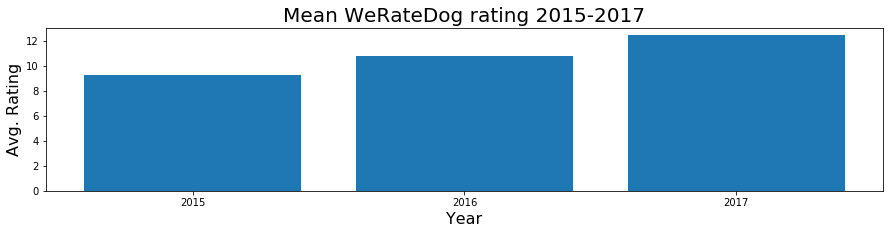

In [130]:
fig = plt.figure(figsize = (15, 3))
ax = fig.add_subplot(111)
plt.bar(['2015', '2016', '2017'], list(val.values))
plt.title('Mean WeRateDog rating 2015-2017', fontsize = 20)
ax.set_xlabel('Year', fontsize = 16)
ax.set_ylabel('Avg. Rating', fontsize = 16)
plt.show();

$\rightarrow$ Clear trend of improving dog ratings from 2015-2017.

### Question 2: how are Tweets spread over day of week?

In [131]:
# weekday: https://docs.python.org/2/library/datetime.html
# Monday is 0 and Sunday is 6
from datetime import datetime as dt
tweet_weekday = df.timestamp.apply(dt.weekday).value_counts()
tweet_weekday = tweet_weekday / tweet_weekday.sum()
tweet_weekday

0    0.163894
2    0.151663
1    0.150196
4    0.141879
3    0.140411
5    0.127202
6    0.124755
Name: timestamp, dtype: float64

In [132]:
# 18% more likely to have a new Tweet on weekdays
tweet_weekday[0:5].mean() / tweet_weekday[5:7].mean()

1.1875728155339806

In [133]:
# avg. Tweets per day
(df.shape[0]) / (2 * 365)

2.8

In [134]:
# Tweets per weekday
(df.shape[0] * tweet_weekday) / ((2 * 365) / 7) # approximately 2 years of posts

0    3.212329
2    2.972603
1    2.943836
4    2.780822
3    2.752055
5    2.493151
6    2.445205
Name: timestamp, dtype: float64

In [135]:
df.timestamp.describe()

count                    2044
unique                   2044
top       2016-08-04 22:52:29
freq                        1
first     2015-11-15 22:32:08
last      2017-08-01 16:23:56
Name: timestamp, dtype: object

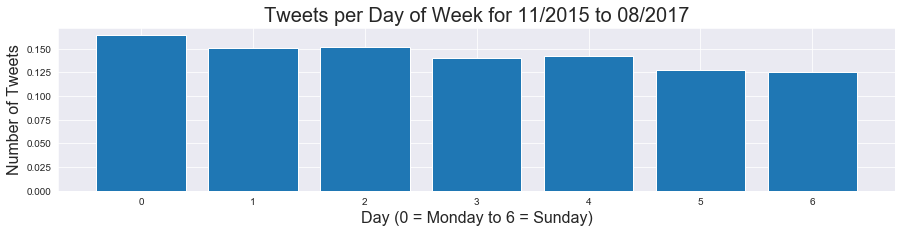

In [136]:
import seaborn as sb
sb.set_style('darkgrid')
fig = plt.figure(figsize = (15, 3))
ax = fig.add_subplot(111)
plt.bar(tweet_weekday.index, tweet_weekday)
plt.title('Tweets per Day of Week for 11/2015 to 08/2017', fontsize = 20)
ax.set_xlabel('Day (0 = Monday to 6 = Sunday)', fontsize = 16)
ax.set_ylabel('Number of Tweets', fontsize = 16)
plt.show();

$\rightarrow$ On the weekend there are less tweets. The highest amount of tweets is on Monday.

### Question 3: When an algorithm identifies a dog on the picture the dog is visible on the picture in a certain structure. Does that structure correlate with how humans like the picture?
Here: Measure by retweet_count how much humans like the dogs.

In [137]:
df.retweet_count.groupby(df.p1_dog).mean()

p1_dog
False    2718.964353
True     2776.593647
Name: retweet_count, dtype: float64

In [138]:
# 4% higher retweet count for dogs identified
df.retweet_count[df.p1_dog == True].mean() / df.retweet_count[df.p1_dog == False].mean()

1.0211953105650502

$\rightarrow$ the average amount of retweets is slightly higher when dogs are identified by the algorithm; more investigation needed to assess the practical relevance/strength of the relationship

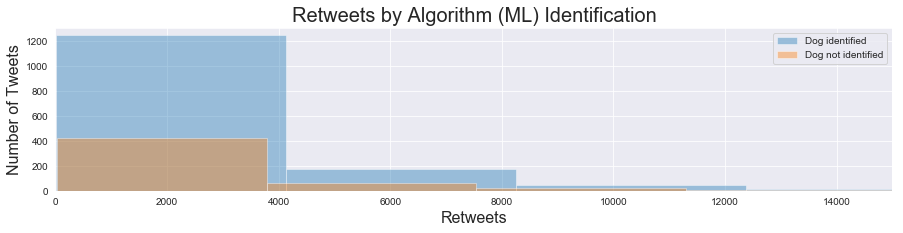

In [139]:
fig = plt.figure(figsize = (15, 3))
ax = fig.add_subplot(111)
(df.retweet_count[df.p1_dog == True]).plot(kind = 'hist', bins = 20, alpha = .4, label = 'Dog identified', xlim = (0,15000))
df.retweet_count[df.p1_dog == False].plot(kind = 'hist', alpha = .4, label = 'Dog not identified')
plt.title('Retweets by Algorithm (ML) Identification', fontsize = 20)
ax.set_xlabel('Retweets', fontsize = 16)
ax.set_ylabel('Number of Tweets', fontsize = 16)
ax.legend();

$\rightarrow$ also no clarity from the picture; we find no clear evidence that the number of retweets and the algorithm identification are influencing each other.

<a id='conclusions'></a>

# Conclusions

WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. We wrangle the WeRateDogs Tweets. We provide a cleaned dataset for further analysis.

So far, we analyzed:
1. The WeRateDogs ratings are clearly increasing over the years.
2. The smallest number of Tweets is to be expected on weekends.
3. We find no clear evidence that the number of retweet and algorithm identification -- the algorithm answers is a dog on the picture? -- are influencing each other.